1. Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного спуска и стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.

In [1]:
import numpy as np
from sklearn.datasets import make_regression

%load_ext autoreload
%autoreload 2

from resource import *

%matplotlib inline
plt.style.use('dark_background')

In [2]:
X_train, y_train, coef = make_regression(n_samples=1000,
                                         n_features=2,
                                         n_informative=2,
                                         n_targets=1,
                                         noise=5,
                                         coef=True,
                                         random_state=42)
# data_train = pd.DataFrame({'X': X_train[:, 0], 'Y': y_train})
data_train = pd.DataFrame({'X1': X_train[:, 0], 'X2': X_train[:, 1], 'Y': y_train})
X = data_train.drop('Y', axis=1)
Y = data_train['Y']

In [3]:
data_train.head()

,X1,X2,Y
0,-0.167118,0.146714,-10.415990
1,-0.020902,0.117327,-6.377265
2,0.150419,0.364961,13.154104
3,0.555604,0.089581,14.935902
4,0.058209,-1.142970,-9.685272


In [4]:
coef

array([40.71064891,  6.60098441])

In [5]:
np.linalg.inv(X.T @ X) @ X.T @ Y

0    40.890188
1     6.700321
dtype: float64

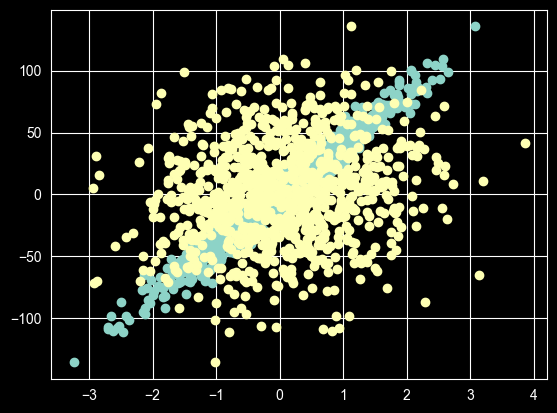

In [6]:
# посмотрим, что получилось

plt.plot(X_train, y_train, 'o')
plt.show()

In [7]:
from sklearn.linear_model import SGDRegressor

skl_regressor = SGDRegressor(max_iter=int(1e6), tol=1e-5, eta0=1e-3)
skl_l = skl_regressor.fit(X, Y)
skl_predictions = skl_regressor.predict(X)

print(skl_regressor.coef_, skl_regressor.intercept_)

[40.88212026  6.69871928] [0.00927369]


## Pseudocode
[Математические методы распознавания образов (курс лекций, В.В.Китов)](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%92.%D0%92.%D0%9A%D0%B8%D1%82%D0%BE%D0%B2%29)

```{python}
1. function gd(X, alpha, epsilon):
2. initialise beta
3. do:
4.  Beta = new_beta
5.  new_Beta = Beta - alpha*grad(X, beta)
6. until dist(new_beta, beta) < epsilon
7. return beta
```

## Stochastic gradient descent

```{python}
1. function sgd(X, alpha, epsilon):
2. initialise beta
3. do:
4.  X = shuffle(X)
5.  for x in X:
6.      Beta = new_beta
7.      new_Beta = Beta - alpha*grad(x, beta)
8. until dist(new_beta, beta) < epsilon
9. return beta
```

In [8]:
%%time
regressor = MyGradientLinearRegression(samples=X, targets=Y, alpha=1e-2, diff_mse=1e-5, print_cost=True)
l = regressor.fit()
w = regressor.get_weights()
w

Cost at iteration 100 is 61.467790109339866, weight=[ 0.56618725 34.60994105  5.87206617]
Cost at iteration 200 is 25.120844630437638, weight=[ 0.15555066 39.9122381   6.59259392]
Cost at iteration 300 is 24.23602212048216, weight=[3.86497866e-02 4.07371015e+01 6.68497515e+00]
Cost at iteration 400 is 24.214152387891794, weight=[1.36639610e-02 4.08659493e+01 6.69767475e+00]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 421 ...
CPU times: total: 375 ms
Wall time: 381 ms


array([1.19143516e-02, 4.08736665e+01, 6.69839482e+00])

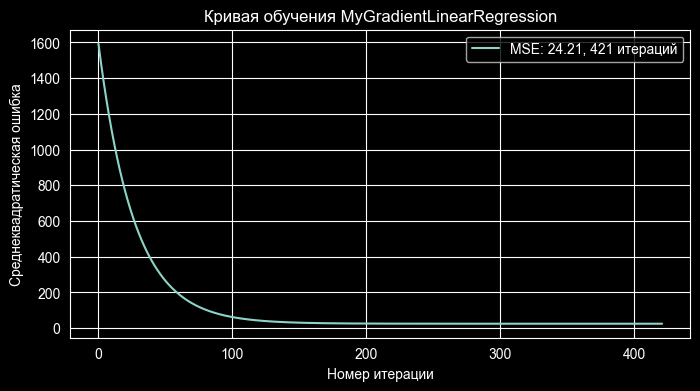

In [9]:
plot_learning_curves(model=regressor)

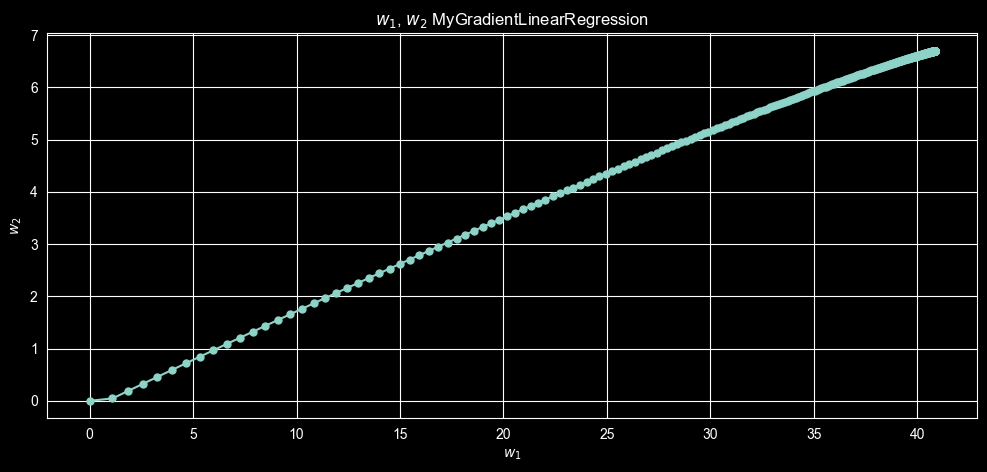

In [10]:
plot_weight_curves(regressor)

In [11]:
class MySGDLinearRegression(MyGradientLinearRegression):

    def _calc_gradient(self):
        n, k = self.samples.shape
        ind = np.random.randint(n)

        pred = self.samples[ind].reshape(-1, k) @ self.weight
        grad = 2 * (pred - self.targets[ind]) @ self.samples[ind].reshape(-1, k)

        return grad

In [12]:
%%time
sgd_regressor = MySGDLinearRegression(samples=X, targets=Y, alpha=1e-2, diff_mse=1e-5, print_cost=True)
sgd_l = sgd_regressor.fit()
sgd_w = sgd_regressor.get_weights()
sgd_w

Cost at iteration 100 is 121.15974642320478, weight=[-0.72058687 30.73805872  6.01097277]
Cost at iteration 200 is 25.17140858300186, weight=[ 0.24460549 39.99412642  7.10094975]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 273 ...
CPU times: total: 141 ms
Wall time: 138 ms


array([ 1.67807526, 41.65022566,  6.02033603])

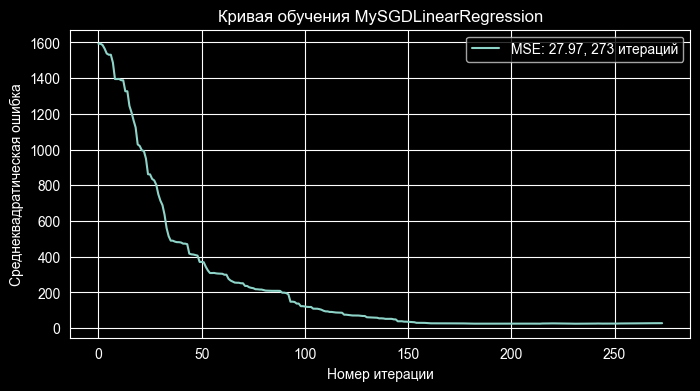

In [13]:
plot_learning_curves(model=sgd_regressor)

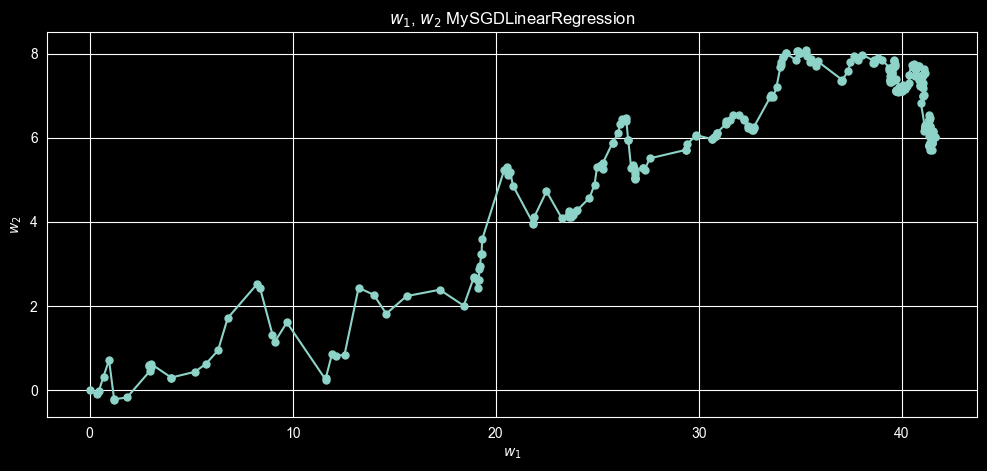

In [14]:
plot_weight_curves(sgd_regressor)

In [15]:
class MyMiniBatchLinearRegression(MyGradientLinearRegression):
    def __init__(self, batch_size=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size

    def _calc_gradient(self):
        n, k = self.samples.shape
        n_batches = n // self.batch_size
        if n % self.batch_size != 0:
            n_batches += 1

        gradient = np.zeros(k)

        for b in range(n_batches):
            start = b * self.batch_size
            end = (b + 1) * self.batch_size
            X_batch = self.samples[start:end]
            y_batch = self.targets[start:end]

            # Compute gradient for the batch
            pred = X_batch @ self.weight
            grad = 2 * (pred - y_batch) @ X_batch
            gradient += grad

        return gradient / n_batches


In [16]:
%%time
mini_bach_regressor = MyMiniBatchLinearRegression(samples=X, targets=Y,
                                                  alpha=1e-2, diff_mse=1e-5,
                                                  batch_size=32,
                                                  print_cost=True)
mini_bach_l = mini_bach_regressor.fit()
mini_bach_w = mini_bach_regressor.get_weights()
mini_bach_w

Model alpha: 0.01, diff_mse: 1e-05, iterations: 12 ...
CPU times: total: 172 ms
Wall time: 163 ms


array([8.38121355e-03, 4.08884456e+01, 6.69973098e+00])

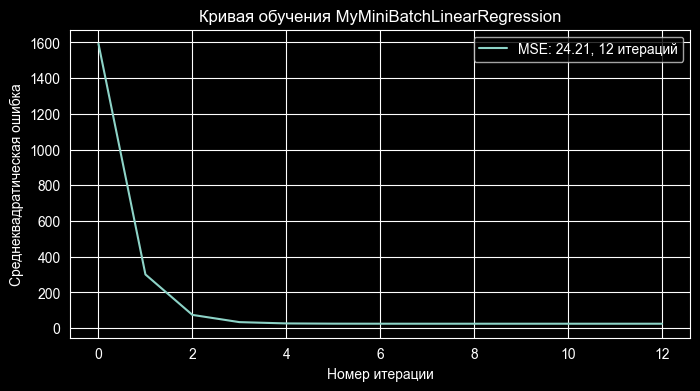

In [17]:
plot_learning_curves(model=mini_bach_regressor)

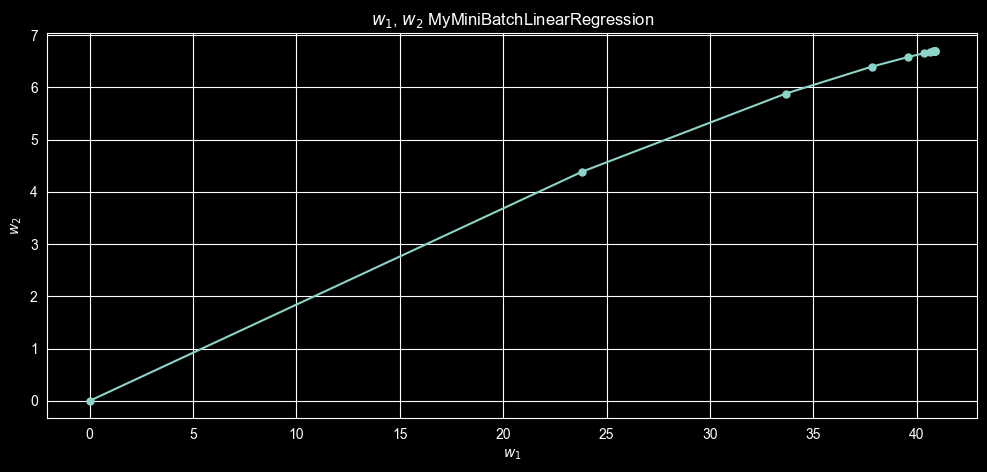

In [18]:
plot_weight_curves(mini_bach_regressor)

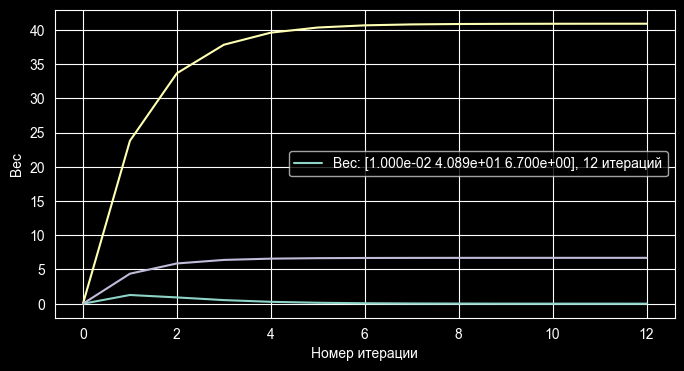

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

learning_path = mini_bach_regressor.weight_dict
plt.plot(learning_path.keys(), learning_path.values())
ax.set_xlabel('Номер итерации')
ax.set_ylabel('Вес')
ax.legend(['Вес: {}, {} итераций'.format(np.round(list(learning_path.values())[-1], 2),
                                         list(learning_path.keys())[-1])])
plt.show()

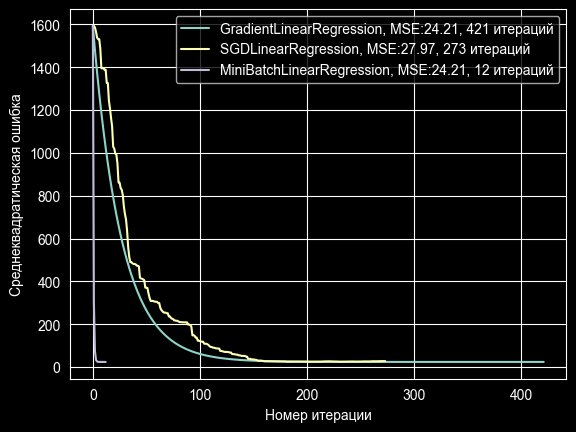

In [20]:
data = [(regressor, 'GradientLinearRegression'),
        (sgd_regressor, 'SGDLinearRegression'),
        (mini_bach_regressor, 'MiniBatchLinearRegression')
        ]

fig, ax = plt.subplots()

for model, label in data:
    learning_path = model.loss_dict
    ax.plot(learning_path.keys(), learning_path.values())

ax.set_xlabel('Номер итерации')
ax.set_ylabel('Среднеквадратическая ошибка')
ax.legend([
    f'{label}, MSE:{str(round(list(model.loss_dict.values())[-1], ndigits=2))}, {list(model.loss_dict.keys())[-1]} итераций'
    for model, label in data])

plt.show()


Разница в количестве итераций между GradientLinearRegression, SGDLinearRegression, которая практически одинакова, может указывать на то, что обе модели сходятся к оптимальным весам схожим образом. SGDLinearRegression сходится быстрее, так как использует стохастический градиентный спуск.

У MiniBatchLinearRegression итераций на порядок меньше, потому что она использует мини-пакетный градиентный спуск, который обновляет веса после каждого прохода по пакету данных (мини-батчу). Это позволяет алгоритму быстрее сходиться к оптимальным значениям весов, особенно при работе с большим объемом данных.

**Преимущества**:
+ частота обновления модели выше, чем при пакетном градиентном спуске, но ниже чем в стохастическом градиентном спуске. Следовательно, этот вариант допускает более надежное схождение;
+ этот метод является вычислительно намного эффективнее, чем пакетный градиентный спуск или стохастический градиентный спуск, поскольку требуется меньше вычислений и ресурсов;

**Среди его недостатков**: использование этого варианта градиентного спуска вводит новый гиперпараметр, который необходимо отрегулировать - размер пакета (число наблюдений в мини-пакете).


2. [*] Добавить в алгоритм градиентного спуска L1 регуляризацию. Сравнить влияние коэффициентов регуляризации L1 и L2 на величину весов для примера из урока (лучше графически).

In [21]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0

    def fit(self, X):
        self.min = X.min(axis=0)
        self.max = X.max(axis=0)
        return self

    def transform(self, X):
        return (X - self.min) / (self.max - self.min)

    def fit_transform(self, X):
        return self.fit(X).transform(X)


# %%
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1

    def fit(self, X):
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse_transform(self, X_scaled):
        return X_scaled * self.std + self.mean

    def inverse_transform_coef(self, coef_scaled):
        return (coef_scaled / self.std).iloc[0]

    def inverse_transform_intercept(self, intercept_scaled, coef_scaled):
        return intercept_scaled - np.sum(coef_scaled * self.mean / self.std)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [22]:
class LassoGradientLinearRegression(MyGradientLinearRegression):
    def __init__(self,
                 l1_penalty=0.001,
                 **kwargs):
        super().__init__(**kwargs)
        self.l1_penalty = l1_penalty

    def mean_squared_error(self):
        yhat = self.predict()
        l1_term = self.l1_penalty * np.sum(np.abs(self.weight[1:]))
        return np.square(yhat - self.targets).mean() + l1_term

    def update(self):
        return self.weight - self.alpha * (self._calc_gradient() + np.sign(self.weight) * self.l1_penalty)


class RidgeGradientLinearRegression(MyGradientLinearRegression):
    def __init__(self,
                 l2_penalty=0.001,
                 **kwargs):
        super().__init__(**kwargs)
        self.l2_penalty = l2_penalty

    def mean_squared_error(self):
        yhat = self.predict()
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weight[1:]))
        return np.square(yhat - self.targets).mean() + l2_term

    def update(self):
        l2_term = self.l2_penalty * np.mean(self.weight[1:])
        return self.weight - self.alpha * (self._calc_gradient() + l2_term)


class ElasticGradientLinearRegression(MyGradientLinearRegression):
    def __init__(self,
                 l1_penalty=0.0,
                 l2_penalty=0.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    def loss(self, yhat, y):
        l1_term = self.l1_penalty * np.sum(np.abs(self.weight[1:]))
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weight[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term

    def update(self):
        l2_term = self.l2_penalty * np.sum(self.weight[1:])
        return self.weight - self.alpha * (self._calc_gradient() + np.sign(self.weight) * self.l1_penalty + l2_term)

In [23]:
%%time
lasso_regressor = LassoGradientLinearRegression(samples=X, targets=Y,
                                                alpha=1e-2, diff_mse=1e-5,
                                                print_cost=True,
                                                l1_penalty=0.001)
lasso_l = lasso_regressor.fit()
lasso_w = lasso_regressor.get_weights()
lasso_w

Cost at iteration 100 is 61.51387965125354, weight=[ 0.56577955 34.60949511  5.87166175]
Cost at iteration 200 is 25.16826601781844, weight=[ 0.15509905 39.91172733  6.5921428 ]
Cost at iteration 300 is 24.283580380018744, weight=[3.81936242e-02 4.07365812e+01 6.68451889e+00]
Cost at iteration 400 is 24.26173609283862, weight=[1.32073589e-02 4.08654275e+01 6.69721793e+00]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 420 ...
CPU times: total: 344 ms
Wall time: 351 ms


array([1.15278284e-02, 4.08728411e+01, 6.69790980e+00])

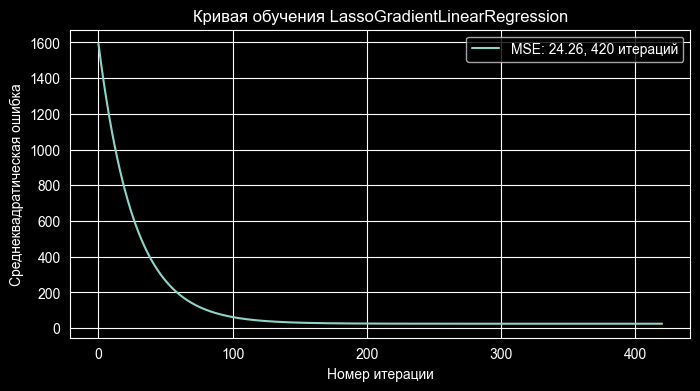

In [24]:
plot_learning_curves(model=lasso_regressor)

In [25]:
%%time
ridge_regressor = RidgeGradientLinearRegression(samples=X, targets=Y,
                                                alpha=1e-2, diff_mse=1e-5,
                                                print_cost=True,
                                                l2_penalty=0.0001)
ridge_l = ridge_regressor.fit()
ridge_w = ridge_regressor.get_weights()
ridge_w

Cost at iteration 100 is 61.538313568372864, weight=[ 0.56552864 34.60923435  5.87140825]
Cost at iteration 200 is 25.20465779964604, weight=[ 0.1545569  39.9111281   6.59160071]
Cost at iteration 300 is 24.32154871562212, weight=[3.75802366e-02 4.07358871e+01 6.68390551e+00]
Cost at iteration 400 is 24.2999430838655, weight=[1.25803090e-02 4.08647125e+01 6.69659067e+00]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 419 ...
CPU times: total: 359 ms
Wall time: 361 ms


array([1.09712439e-02, 4.08718157e+01, 6.69725299e+00])

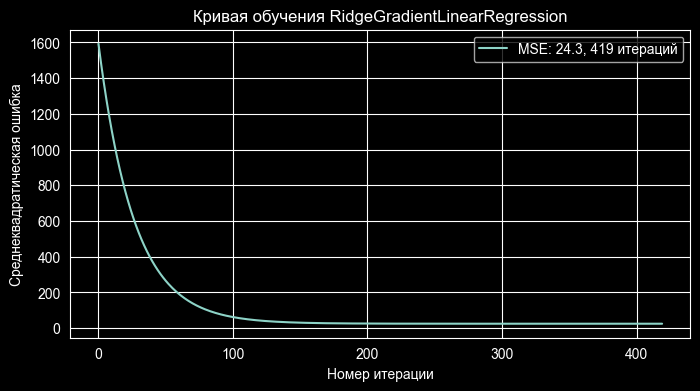

In [26]:
plot_learning_curves(model=ridge_regressor)

In [27]:
%%time
elastic_regressor = ElasticGradientLinearRegression(samples=X, targets=Y,
                                                    alpha=1e-2, diff_mse=1e-5,
                                                    print_cost=True,
                                                    l1_penalty=0.0001, l2_penalty=0.0001)
elastic_l = elastic_regressor.fit()
elastic_w = elastic_regressor.get_weights()
elastic_w

Cost at iteration 100 is 61.48617325927213, weight=[ 0.5648293  34.60848309  5.87070993]
Cost at iteration 200 is 25.124935042784795, weight=[ 0.15351806 39.90996711  6.59056246]
Cost at iteration 300 is 24.236688724363653, weight=[3.64651750e-02 4.07346208e+01 6.68279036e+00]
Cost at iteration 400 is 24.214267663416432, weight=[1.14511063e-02 4.08634237e+01 6.69546102e+00]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 424 ...
CPU times: total: 359 ms
Wall time: 345 ms


array([9.49612484e-03, 4.08720146e+01, 6.69626037e+00])

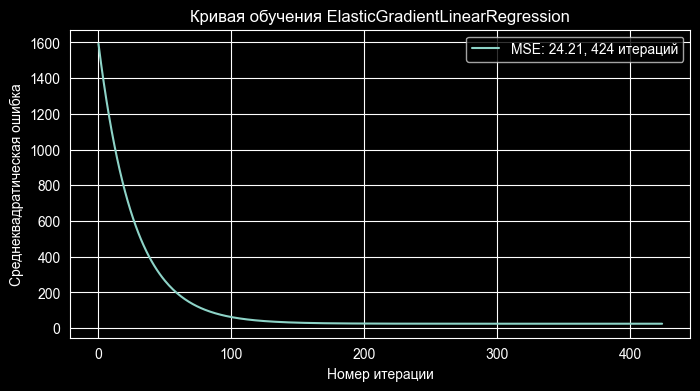

In [28]:
plot_learning_curves(model=elastic_regressor)

Данные из урока

In [29]:
X_train = np.array([1, 1, 2, 1, 3, 0, 5, 10, 1, 2])  # стаж репетитора
y_train = np.array([45, 55, 50, 59, 65, 35, 75, 80, 50, 60])  # средний балл ЕГЭ (целевая переменная)

# выведем табличку с данными
data_train = pd.DataFrame({'X': X_train, 'Y': y_train})
X = data_train.drop('Y', axis=1)
Y = data_train['Y']

In [30]:
data_train.head()

,X,Y
0,1,45
1,1,55
2,2,50
3,1,59
4,3,65


In [31]:
%%time
lec_regressor = MyGradientLinearRegression(samples=X, targets=Y,
                                            alpha=1e-2, diff_mse=1e-5,
                                            print_cost=True)
lec_l = lec_regressor.fit()
lec_w = lec_regressor.get_weights()
lec_w

Cost at iteration 100 is 178.059789558226, weight=[31.55556282  6.80551471]
Cost at iteration 200 is 62.27201779786448, weight=[41.72005111  4.92856419]
Cost at iteration 300 is 47.95696600063397, weight=[45.29401889  4.2686037 ]
Cost at iteration 400 is 46.18717023686794, weight=[46.55067298  4.03655291]
Cost at iteration 500 is 45.96836718328417, weight=[46.99252908  3.9549608 ]
Cost at iteration 600 is 45.94131616573866, weight=[47.1478915   3.92627194]
Cost at iteration 700 is 45.93797179947749, weight=[47.20251897  3.91618456]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 700 ...
CPU times: total: 562 ms
Wall time: 554 ms


array([47.20251897,  3.91618456])

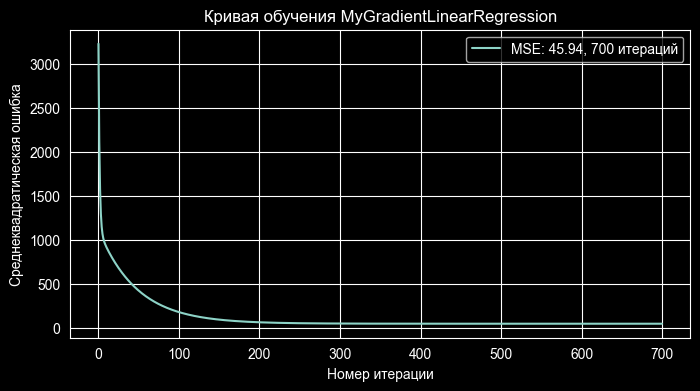

In [32]:
plot_learning_curves(model=lec_regressor)

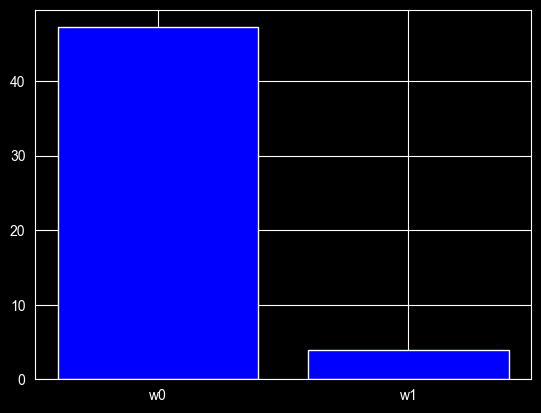

In [33]:
plot_weights(lec_w)

In [34]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)
x_scaled

,X
0,-0.542105
1,-0.542105
2,-0.203289
3,-0.542105
4,0.135526
5,-0.880920
6,0.813157
7,2.507234
8,-0.542105
9,-0.203289


In [35]:
%%time
lec_lasso_regressor = LassoGradientLinearRegression(samples=x_scaled, targets=Y,
                                                    alpha=1e-2, diff_mse=1e-5,
                                                    print_cost=True,
                                                    l1_penalty=0.001)
lec_lasso_l = lec_lasso_regressor.fit()
lec_lasso_w = lec_lasso_regressor.get_weights()
lec_lasso_w

Cost at iteration 100 is 105.8082631317402, weight=[49.85307781  9.74571702]
Cost at iteration 200 is 47.02841668749703, weight=[56.39869684 11.24970267]
Cost at iteration 300 is 45.968821100134235, weight=[57.26677393 11.49426663]
Cost at iteration 400 is 45.949423395163706, weight=[57.38189793 11.53403532]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 411 ...
CPU times: total: 328 ms
Wall time: 338 ms


array([57.38540547, 11.53543395])

In [36]:
# https://stackoverflow.com/questions/64668082/how-linear-regression-coefficients-are-stored-in-sklearn-pipelines/64671638#64671638
coef = scaler.inverse_transform_coef(coef_scaled=lec_lasso_w[1])
bias = scaler.inverse_transform_intercept(intercept_scaled=lec_lasso_w[0],
                                          coef_scaled=lec_lasso_w[1])
print(coef, bias)

3.908383400415926 47.22360862760826


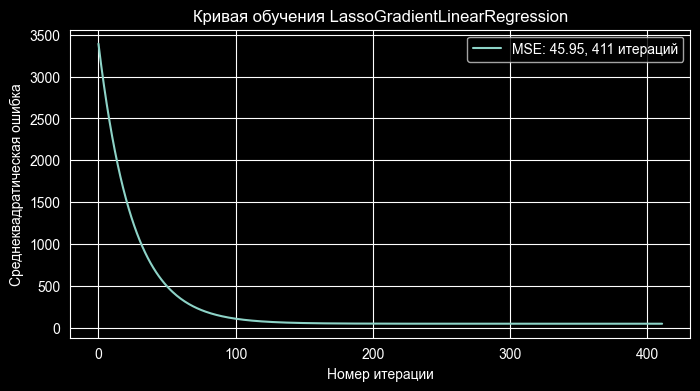

In [37]:
plot_learning_curves(model=lec_lasso_regressor)

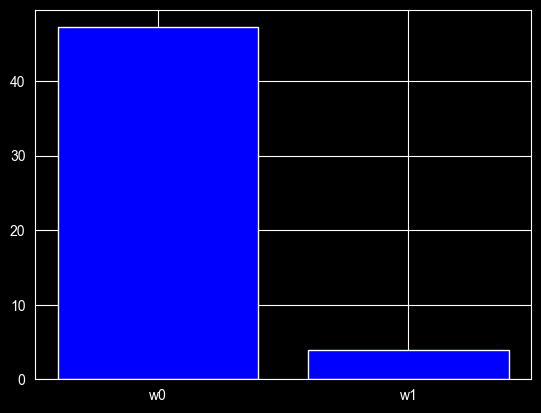

In [38]:
plot_weights([bias, coef])

In [39]:
%%time
lec_ridge_regressor = RidgeGradientLinearRegression(samples=x_scaled, targets=Y,
                                                    alpha=1e-2, diff_mse=1e-5,
                                                    print_cost=True,
                                                    l2_penalty=0.001)
lec_ridge_l = lec_ridge_regressor.fit()
lec_ridge_w = lec_ridge_regressor.get_weights()
lec_ridge_w

Cost at iteration 100 is 105.89993171190693, weight=[49.85016301  9.74264261]
Cost at iteration 200 is 47.09250792654, weight=[56.39400973 11.24459806]
Cost at iteration 300 is 46.025239188189445, weight=[57.26162667 11.48858331]
Cost at iteration 400 is 46.00467380467107, weight=[57.37665307 11.52821751]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 419 ...
CPU times: total: 359 ms
Wall time: 356 ms


array([57.38225771, 11.53046213])

In [40]:
coef = scaler.inverse_transform_coef(coef_scaled=lec_ridge_w[1])
bias = scaler.inverse_transform_intercept(intercept_scaled=lec_ridge_w[0],
                                          coef_scaled=lec_ridge_w[1])
print(coef, bias)

3.9066988736102224 47.224840639671505


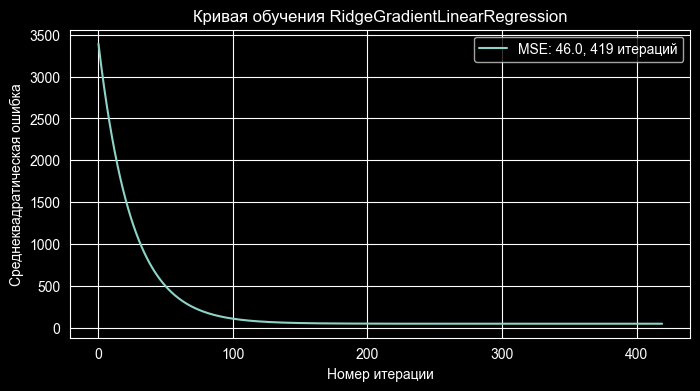

In [41]:
plot_learning_curves(model=lec_ridge_regressor)

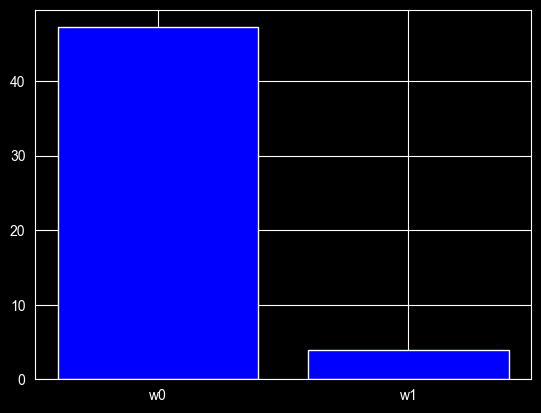

In [42]:
plot_weights([bias, coef])

In [50]:
%%time
lec_elastic_regressor = ElasticGradientLinearRegression(samples=x_scaled, targets=Y,
                                                    alpha=1e-2, diff_mse=1e-5,
                                                    print_cost=True,
                                                    l1_penalty=0.001, l2_penalty=0.001)
lec_elastic_l = lec_elastic_regressor.fit()
lec_elastic_w = lec_elastic_regressor.get_weights()
lec_elastic_w

Cost at iteration 100 is 105.86052523966846, weight=[49.84972948  9.74217756]
Cost at iteration 200 is 47.03056543367053, weight=[56.39351877 11.24405747]
Cost at iteration 300 is 45.95943738416393, weight=[57.26112811 11.48803044]
Cost at iteration 400 is 45.93826183695396, weight=[57.3761535  11.52766265]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 423 ...
CPU times: total: 422 ms
Wall time: 412 ms


array([57.38268788, 11.53028875])

In [51]:
coef = scaler.inverse_transform_coef(coef_scaled=lec_elastic_w[1])
bias = scaler.inverse_transform_intercept(intercept_scaled=lec_elastic_w[0],
                                          coef_scaled=lec_elastic_w[1])
print(coef, bias)

3.906640129449676 47.22542354381425
